In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from cluster_util.spark_util import SparkUtil
from cluster_util.hive_util import HiveUtil

## Init spark and check db

In [6]:
spark = SparkUtil().build_spark_session(app_name="Shared Bike Analysis System notebook")

2021-12-06 22:14:12,773	File "spark_util.py", line 25	INFO: Build spark session ...
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/06 22:14:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark.sql('show databases').show()

+----------+
| namespace|
+----------+
|   default|
|sharedbike|
+----------+



In [8]:
spark.sql('use sharedbike')
spark.sql('show tables').show()

+----------+------------+-----------+
| namespace|   tableName|isTemporary|
+----------+------------+-----------+
|sharedbike|trip_details|      false|
+----------+------------+-----------+



In [9]:
partitions_list = spark.sql('SHOW PARTITIONS {}'.format('trip_details'))
partitions_list.show()

+---------+
|partition|
+---------+
| ptd=2018|
| ptd=2019|
| ptd=2020|
| ptd=2021|
+---------+



In [10]:
partitions_list.collect()

[Row(partition='ptd=2018'),
 Row(partition='ptd=2019'),
 Row(partition='ptd=2020'),
 Row(partition='ptd=2021')]

## Basic analysis by year

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
ptd = partitions_list.collect()
desc_list_names = ['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']


for year in ptd:
    cur_year = year[0]
    print(cur_year)
    df_by_year = spark.sql('select {} from trip_details where {};'.format(','.join(desc_list_names), cur_year))
    df_by_year.toPandas().describe().T

ptd=2018


,count,mean,std,min,25%,50%,75%,max
duration,72763.0,34.548795,106.853523,1.000000,7.000000,13.000000,26.000000,1440.000000
start_lat,72763.0,34.034630,0.041893,33.710979,34.039188,34.046070,34.050480,34.074829
start_lon,72763.0,-118.286616,0.081285,-118.491341,-118.265381,-118.255798,-118.246422,-118.218849
end_lat,72763.0,34.034709,0.041512,33.710979,34.038609,34.045540,34.049301,34.074829
end_lon,72763.0,-118.286937,0.082233,-118.491341,-118.265381,-118.255882,-118.245880,-118.218849
plan_duration,72763.0,30.291137,69.936899,1.000000,1.000000,30.000000,30.000000,365.000000
trip_route_type,72763.0,1.154708,0.361628,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,72144.0,2.135853,1.016869,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,72763.0,1.033107,0.178918,1.000000,1.000000,1.000000,1.000000,2.000000
distance,72763.0,22.389814,22.392445,0.000000,9.671472,18.133419,31.156162,637.581543


ptd=2019


,count,mean,std,min,25%,50%,75%,max
duration,276943.0,26.121343,90.388375,1.000000,6.000000,11.000000,21.000000,1440.000000
start_lat,276943.0,34.037040,0.050631,33.710979,34.039982,34.046810,34.051941,34.177662
start_lon,276943.0,-118.280844,0.068683,-118.495422,-118.270920,-118.256668,-118.247162,-118.231277
end_lat,276943.0,34.036799,0.050564,33.710979,34.039871,34.046810,34.050911,34.177662
end_lon,276943.0,-118.281027,0.069339,-118.495422,-118.271027,-118.256668,-118.246422,-118.000000
plan_duration,276943.0,57.457863,107.068773,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,276943.0,1.151302,0.358344,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,276576.0,2.493741,0.969261,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,276943.0,1.560354,0.680624,1.000000,1.000000,1.000000,2.000000,3.000000
distance,276943.0,22.495716,21.976421,0.000000,8.924728,16.918259,30.436466,838.342163


ptd=2020


,count,mean,std,min,25%,50%,75%,max
duration,199127.0,33.591567,99.645267,1.000000,7.000000,15.000000,27.000000,1440.000000
start_lat,199127.0,34.078629,0.813569,33.928459,34.040600,34.048401,34.056969,55.705528
start_lon,199127.0,-118.068532,5.852517,-118.491341,-118.290092,-118.260948,-118.252441,37.606541
end_lat,199127.0,34.077472,0.801943,33.928459,34.040600,34.048401,34.056808,55.705528
end_lon,199127.0,-118.074981,5.768745,-118.491341,-118.290092,-118.260948,-118.252441,37.606541
plan_duration,199127.0,57.399429,106.117360,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,199127.0,1.202916,0.402171,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,194501.0,2.633524,0.902745,1.000000,2.000000,3.000000,3.000000,4.000000
bike_type,199127.0,1.603509,0.662184,1.000000,1.000000,2.000000,2.000000,3.000000
distance,199127.0,298.572632,9137.059570,0.000000,6.706501,17.265965,32.601288,304154.843750


ptd=2021


,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592951,35.449078,0.000000,4.025301,20.554560,41.013824,517.316467


## Feature analysis

In [13]:
# Get file name automatically
from common.file_utils import FileUtils
trip_details_file_name = None
files_name = FileUtils.get_file_list_under_dir('results/trip_details/')
for i in files_name:
    if '.csv' in i:
        trip_details_file_name = i[1:]
        break
print(trip_details_file_name)

part-00000-62a32cce-e94a-47b5-bfb3-80e1c9e4091f-c000.csv


In [14]:
trip_data_by_year_df = pd.read_csv('results/trip_details/{}'.format(trip_details_file_name))
trip_data_by_year_df.shape

(702822, 25)

In [15]:
# check missing value
trip_data_by_year_df.isna().sum()

trip_id               0
duration              0
start_station         0
start_lat             0
start_lon             0
end_station           0
end_lat               0
end_lon               0
bike_id              16
plan_duration         0
trip_route_type       0
passholder_type    5613
bike_type             0
distance              0
distance_cal          0
city_name             0
used_date             0
used_hour             0
season                0
holiday               0
workingday            0
start_datetime        0
end_datetime          0
start_hour            0
ptd                   0
dtype: int64

In [16]:
# remove missing value
trip_data_by_year_df = trip_data_by_year_df.dropna(how='any')
trip_data_by_year_df.isnull().sum()

trip_id            0
duration           0
start_station      0
start_lat          0
start_lon          0
end_station        0
end_lat            0
end_lon            0
bike_id            0
plan_duration      0
trip_route_type    0
passholder_type    0
bike_type          0
distance           0
distance_cal       0
city_name          0
used_date          0
used_hour          0
season             0
holiday            0
workingday         0
start_datetime     0
end_datetime       0
start_hour         0
ptd                0
dtype: int64

In [17]:
trip_data_by_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697195 entries, 0 to 702821
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          697195 non-null  int64  
 1   duration         697195 non-null  int64  
 2   start_station    697195 non-null  int64  
 3   start_lat        697195 non-null  float64
 4   start_lon        697195 non-null  float64
 5   end_station      697195 non-null  int64  
 6   end_lat          697195 non-null  float64
 7   end_lon          697195 non-null  float64
 8   bike_id          697195 non-null  float64
 9   plan_duration    697195 non-null  int64  
 10  trip_route_type  697195 non-null  int64  
 11  passholder_type  697195 non-null  float64
 12  bike_type        697195 non-null  int64  
 13  distance         697195 non-null  float64
 14  distance_cal     697195 non-null  float64
 15  city_name        697195 non-null  object 
 16  used_date        697195 non-null  obje

In [18]:
trip_data_by_year_df['passholder_type'] = trip_data_by_year_df['passholder_type'].astype('int') 
trip_data_by_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697195 entries, 0 to 702821
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          697195 non-null  int64  
 1   duration         697195 non-null  int64  
 2   start_station    697195 non-null  int64  
 3   start_lat        697195 non-null  float64
 4   start_lon        697195 non-null  float64
 5   end_station      697195 non-null  int64  
 6   end_lat          697195 non-null  float64
 7   end_lon          697195 non-null  float64
 8   bike_id          697195 non-null  float64
 9   plan_duration    697195 non-null  int64  
 10  trip_route_type  697195 non-null  int64  
 11  passholder_type  697195 non-null  int64  
 12  bike_type        697195 non-null  int64  
 13  distance         697195 non-null  float64
 14  distance_cal     697195 non-null  float64
 15  city_name        697195 non-null  object 
 16  used_date        697195 non-null  obje

In [19]:
trip_data_by_year_df.shape

(697195, 25)

In [20]:
trip_data_by_year_df = trip_data_by_year_df[ trip_data_by_year_df['city_name'] == 'LA']
trip_data_by_year_df.shape

(696826, 25)

In [21]:
trip_data_by_year_df.head(3)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,...,city_name,used_date,used_hour,season,holiday,workingday,start_datetime,end_datetime,start_hour,ptd
0,163724638,25,4543,33.957180,-118.451248,4543,33.957180,-118.451248,15147.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:55:00.000-07:00,2021-06-16T12:20:00.000-07:00,2021-06-16 11:00:00,2021
1,163724845,34,4211,33.984928,-118.469963,4215,34.014309,-118.491341,16142.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:55:00.000-07:00,2021-06-16T12:29:00.000-07:00,2021-06-16 11:00:00,2021
2,163724844,33,4211,33.984928,-118.469963,4215,34.014309,-118.491341,16133.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:56:00.000-07:00,2021-06-16T12:29:00.000-07:00,2021-06-16 11:00:00,2021


Feature descriptions from https://bikeshare.metro.net/about/data/

trip_id: Locally unique integer that identifies the trip

duration: Length of trip in minutes*

start_time: The date/time when the trip began, presented in ISO 8601 format in local time

end_time: The date/time when the trip ended, presented in ISO 8601 format in local time

start_station: The station ID where the trip originated

start_lat: The latitude of the station where the trip originated

start_lon: The longitude of the station where the trip originated

end_station: The station ID where the trip terminated

end_lat: The latitude of the station where the trip terminated

end_lon: The longitude of the station where the trip terminated

bike_id: Locally unique integer that identifies the bike

plan_duration: The number of days that the plan the passholder is using entitles them to ride; 0 is used for a single ride plan (Walk-up)

trip_route_category: "Round Trip" for trips starting and ending at the same station or "One Way" for all other trips

passholder_type: The name of the passholder's plan

*units are actually in but each instance is a multiple of 60 i.e. a whole minute number. We will convert this to minutes

Other features are not officially described by Metro Bike Share

Starting Lat-Long and Ending Lat-Long appear to be repetitions of previous station data and can be dropped safely

Remaining features appear to be LA geographic information not relevant to this study, many of which include large amounts of missing data. These will also be dropped.

In [22]:
if trip_data_by_year_df.index is None and len(trip_data_by_year_df.index) == 0:
    trip_data_by_year_df.set_index('trip_id', inplace=True)
trip_data_by_year_df.head(3)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,...,city_name,used_date,used_hour,season,holiday,workingday,start_datetime,end_datetime,start_hour,ptd
0,163724638,25,4543,33.957180,-118.451248,4543,33.957180,-118.451248,15147.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:55:00.000-07:00,2021-06-16T12:20:00.000-07:00,2021-06-16 11:00:00,2021
1,163724845,34,4211,33.984928,-118.469963,4215,34.014309,-118.491341,16142.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:55:00.000-07:00,2021-06-16T12:29:00.000-07:00,2021-06-16 11:00:00,2021
2,163724844,33,4211,33.984928,-118.469963,4215,34.014309,-118.491341,16133.0,1,...,LA,6/16/2021,11,2,0,1,2021-06-16T11:56:00.000-07:00,2021-06-16T12:29:00.000-07:00,2021-06-16 11:00:00,2021


In [23]:
trip_data_by_year_df[['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration', 
                      'trip_route_type', 'passholder_type', 'bike_type', 'distance', 
                      'season', 'holiday', 'workingday']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,696826.0,32.443743,96.880376,1.000000,7.000000,14.000000,26.000000,1440.000000
start_lat,696826.0,34.038269,0.042759,33.710979,34.031399,34.046612,34.051941,34.186569
start_lon,696826.0,-118.297652,0.080384,-118.495422,-118.291496,-118.260139,-118.250183,-118.218849
end_lat,696826.0,34.038100,0.042575,33.710979,34.031052,34.046520,34.051941,34.186569
end_lon,696826.0,-118.297972,0.081028,-118.495422,-118.291718,-118.260139,-118.250183,-118.000000
plan_duration,696826.0,52.309412,102.240603,1.000000,1.000000,30.000000,30.000000,365.000000
trip_route_type,696826.0,1.186451,0.389471,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,696826.0,2.457213,0.981104,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,696826.0,1.455076,0.628198,1.000000,1.000000,1.000000,2.000000,3.000000
distance,696826.0,24.374916,26.587788,0.000000,8.194323,17.920748,33.529335,838.342160


### Countplot in categorical variable

<AxesSubplot:xlabel='trip_route_type', ylabel='count'>

<AxesSubplot:xlabel='passholder_type', ylabel='count'>

<AxesSubplot:xlabel='bike_type', ylabel='count'>

<AxesSubplot:xlabel='season', ylabel='count'>

<AxesSubplot:xlabel='holiday', ylabel='count'>

<AxesSubplot:xlabel='workingday', ylabel='count'>

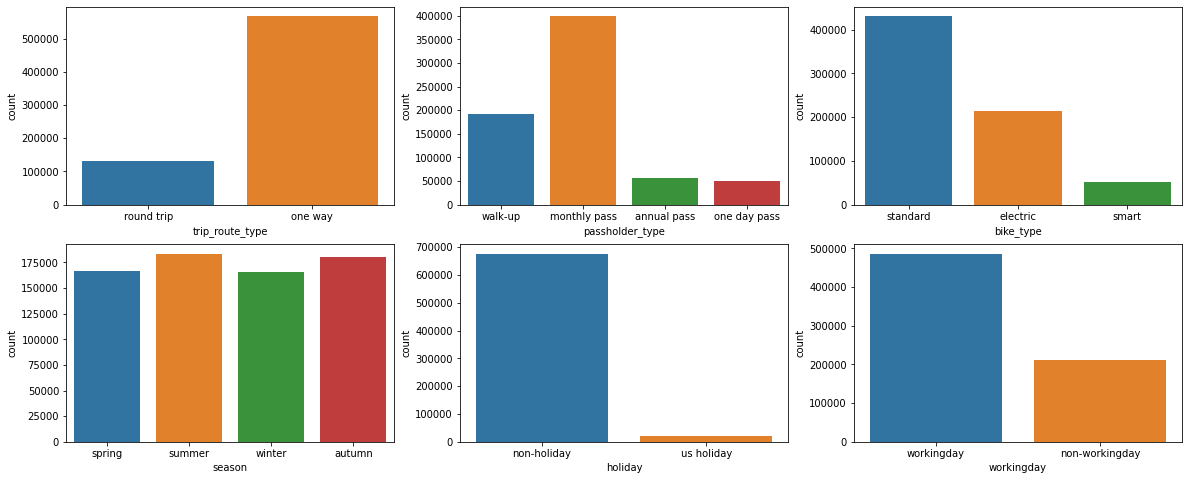

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)

# col_name = ['trip_route_type', 'passholder_type', 'bike_type', 'season', 'holiday', 'workingday']

from copy import deepcopy
trip_data_dscrpt_df = deepcopy(trip_data_by_year_df)

trip_route_type = {1: 'one way', 2: 'round trip'}
trip_data_dscrpt_df['trip_route_type'] = [trip_route_type[x] for x in trip_data_by_year_df['trip_route_type']]
passholder_type = {1: 'walk-up', 2: 'one day pass', 3: 'monthly pass', 4: 'annual pass'}
trip_data_dscrpt_df['passholder_type'] = [passholder_type[x] for x in trip_data_by_year_df['passholder_type']]
bike_type = {1: 'standard', 2: 'electric', 3: 'smart'}
trip_data_dscrpt_df['bike_type'] = [bike_type[x] for x in trip_data_by_year_df['bike_type']]
season = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'autumn'}
trip_data_dscrpt_df['season'] = [season[x] for x in trip_data_by_year_df['season']]
holiday = {1: 'us holiday', 0: 'non-holiday'}
trip_data_dscrpt_df['holiday'] = [holiday[x] for x in trip_data_by_year_df['holiday']]
workingday = {1: 'workingday', 0: 'non-workingday'}
trip_data_dscrpt_df['workingday'] = [workingday[x] for x in trip_data_by_year_df['workingday']]

# print(trip_data_dscrpt_df['passholder_type'].value_counts())

sns.countplot(trip_data_dscrpt_df['trip_route_type'], ax=axes[0][0])
sns.countplot(trip_data_dscrpt_df['passholder_type'], ax=axes[0][1])
sns.countplot(trip_data_dscrpt_df['bike_type'], ax=axes[0][2])
sns.countplot(trip_data_dscrpt_df['season'], ax=axes[1][0])
sns.countplot(trip_data_dscrpt_df['holiday'], ax=axes[1][1])
sns.countplot(trip_data_dscrpt_df['workingday'], ax=axes[1][2])

### Load Data by hourly

In [26]:
# Get file name automatically
from common.file_utils import FileUtils
app_trip_cnt_by_hour_file_name = None
files_name = FileUtils.get_file_list_under_dir('results/app/app_trip_cnt_by_hour/')
for i in files_name:
    if '.csv' in i:
        app_trip_cnt_by_hour_file_name = i[1:]
        break
print(app_trip_cnt_by_hour_file_name)

part-00000-29ad50e8-ecef-4428-9c48-44cc84b657c2-c000.csv


In [27]:
app_trip_cnt_by_hour_df = pd.read_csv('results/app/app_trip_cnt_by_hour/{}'.format(app_trip_cnt_by_hour_file_name))
app_trip_cnt_by_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24663 entries, 0 to 24662
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   start_hour                        24663 non-null  object
 1   used_count                        24663 non-null  int64 
 2   total_duration                    24663 non-null  int64 
 3   plan_duration_day_count           24663 non-null  int64 
 4   plan_duration_month_count         24663 non-null  int64 
 5   plan_duration_year_count          24663 non-null  int64 
 6   trip_route_type_one_way_count     24663 non-null  int64 
 7   trip_route_type_round_trip_count  24663 non-null  int64 
 8   passholder_type_walk_up_count     24663 non-null  int64 
 9   passholder_type_one_day_count     24663 non-null  int64 
 10  passholder_type_monthly_count     24663 non-null  int64 
 11  passholder_type_annual_count      24663 non-null  int64 
 12  bike_type_standard

In [28]:
app_trip_cnt_by_hour_df.head(3)

,start_hour,used_count,total_duration,plan_duration_day_count,plan_duration_month_count,plan_duration_year_count,trip_route_type_one_way_count,trip_route_type_round_trip_count,passholder_type_walk_up_count,passholder_type_one_day_count,...,passholder_type_annual_count,bike_type_standard_count,bike_type_electric_count,bike_type_smart_count,season,holiday,workingday,hour_is_morning_evening,hour_is_noon,hour_is_idle
0,2018-10-01 00:00:00,7,532,5,2,0,2,5,5,0,...,0,7,0,0,4,0,1,0,0,1
1,2018-10-01 01:00:00,2,24,1,1,0,2,0,1,0,...,0,2,0,0,4,0,1,0,0,1
2,2018-10-01 02:00:00,2,10,1,1,0,2,0,1,0,...,0,2,0,0,4,0,1,0,0,1


In [29]:
app_trip_cnt_by_hour_df.describe().T

,count,mean,std,min,25%,50%,75%,max
used_count,24663.0,28.482058,23.734020,1.0,7.0,24.0,44.0,330.0
total_duration,24663.0,922.309370,1116.099273,1.0,151.0,597.0,1306.0,28466.0
plan_duration_day_count,24663.0,9.309776,10.978288,0.0,2.0,6.0,14.0,247.0
plan_duration_month_count,24663.0,16.443174,14.783176,0.0,4.0,13.0,24.0,115.0
plan_duration_year_count,24663.0,2.724973,3.309572,0.0,0.0,2.0,4.0,36.0
trip_route_type_one_way_count,24663.0,23.175323,19.939030,0.0,6.0,19.0,36.0,259.0
trip_route_type_round_trip_count,24663.0,5.306735,5.749567,0.0,1.0,4.0,8.0,82.0
passholder_type_walk_up_count,24663.0,7.813648,9.177963,0.0,1.0,5.0,11.0,163.0
passholder_type_one_day_count,24663.0,1.987877,3.711656,0.0,0.0,0.0,3.0,149.0
passholder_type_monthly_count,24663.0,16.174188,14.781297,0.0,4.0,13.0,24.0,115.0


### Pointplot in categorical variable

<AxesSubplot:xlabel='workingday', ylabel='used_count'>

<AxesSubplot:xlabel='season', ylabel='used_count'>

<AxesSubplot:xlabel='holiday', ylabel='used_count'>

<AxesSubplot:xlabel='hour_is_morning_evening', ylabel='used_count'>

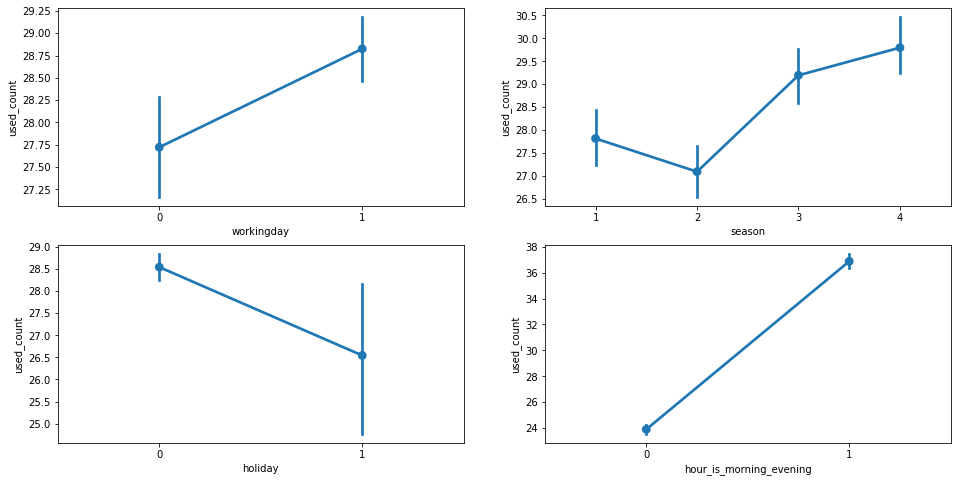

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.pointplot(data=app_trip_cnt_by_hour_df, x='workingday', y='used_count', ax=axes[0][0])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='season', y='used_count', ax=axes[0][1])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='holiday', y='used_count', ax=axes[1][0])
sns.pointplot(data=app_trip_cnt_by_hour_df, x='hour_is_morning_evening', y='used_count', ax=axes[1][1])

### Correlation matrix

<AxesSubplot:>

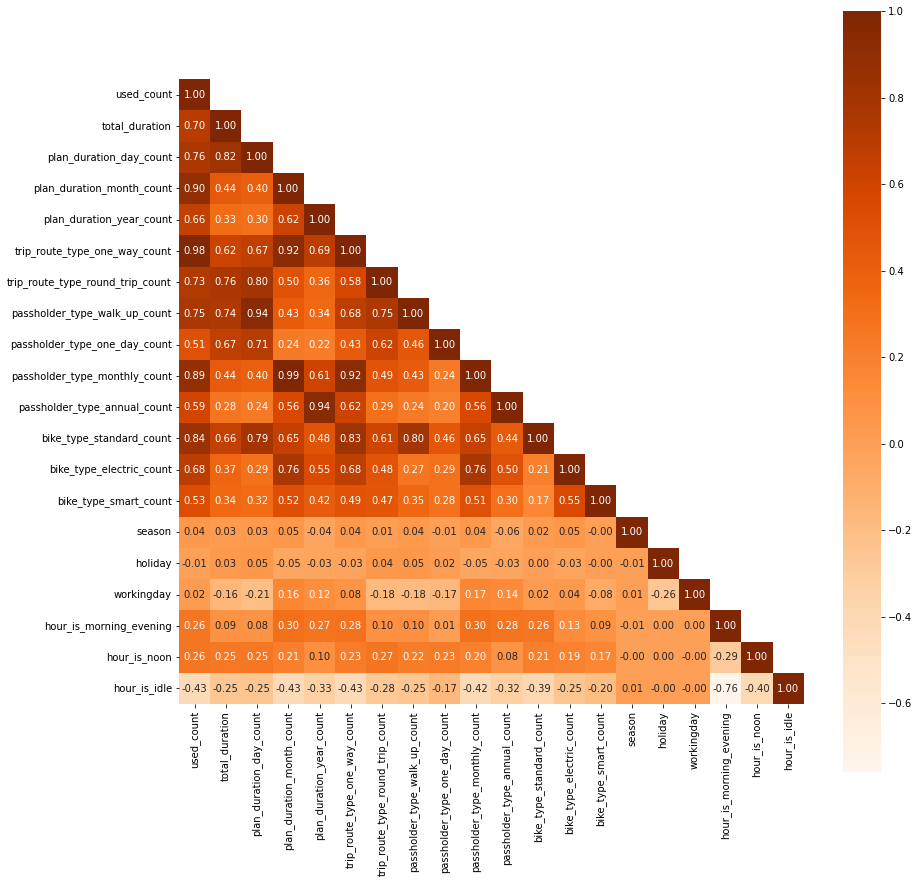

In [31]:
corr_matrix = app_trip_cnt_by_hour_df.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(14, 14)
sns.heatmap(data=corr_matrix,
            mask=mask,
            cmap='Oranges',
            fmt='.2f',
            square=True,
            annot=True,
            cbar=True)

# data[u'col'].corr(data[u'col']) # specific corr

### Covariance matrix

In [32]:
# import numpy as np
cov_matrix = np.cov(app_trip_cnt_by_hour_df)

print(cov_matrix)
# import matplotlib.pyplot as mp
# sns.heatmap(cov_matrix, center=0, annot=True) #  , xticklabels=list('abcd'), yticklabels=list('ABCD')
# mp.show()

TypeError: can only concatenate str (not "int") to str

## Cluster analysis - kmeans

In [33]:
from sklearn.cluster import KMeans
from sklearn import cluster
cluster.DBSCAN().get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

In [36]:
trip_data_by_year_df_2021 = trip_data_by_year_df[trip_data_by_year_df.ptd == 2021]
trip_data_by_year_df_2021.shape

(153980, 25)

In [37]:
coordinate_data = trip_data_by_year_df_2021.loc[:,['start_lon','start_lat']] # get all records of ’start_lon, start_lat’ columns，df.loc[0, :] get [0] line

In [38]:
coordinate_data.head(10)

,start_lon,start_lat
0,-118.451248,33.957180
1,-118.469963,33.984928
2,-118.469963,33.984928
3,-118.250587,34.058960
4,-118.260139,34.043732
5,-118.291939,34.105782
6,-118.481552,33.995560
7,-118.275002,34.056808
8,-118.243248,34.045181
9,-118.471550,33.984341


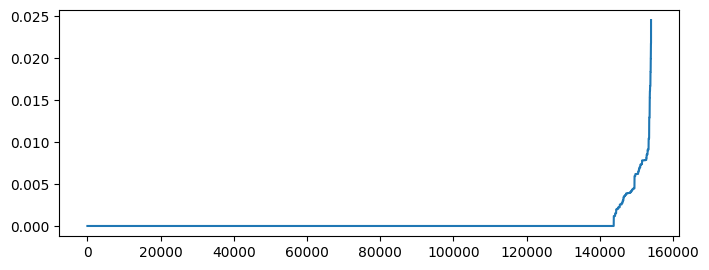

In [98]:
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

parking_min_bikes = 300
min_neighbors = 300
nbrs = NearestNeighbors(n_neighbors=parking_min_bikes).fit(coordinate_data)  # 找到距离最近的500个点
distances, indices = nbrs.kneighbors(coordinate_data)  # 计算每个点最近的500个点的距离
dist = distances[:, (min_neighbors-1)]
dist_ = np.sort(dist)
plt.figure(figsize=(8, 3))
plt.plot(dist_)

categories  |  samples :
-1      10202
 3       7825
 6       6768
 12      6147
 20      4634
        ...  
 89       317
 150      309
 61       307
 139      306
 153      302
Length: 155, dtype: int64
DBI=1.4304855484164847


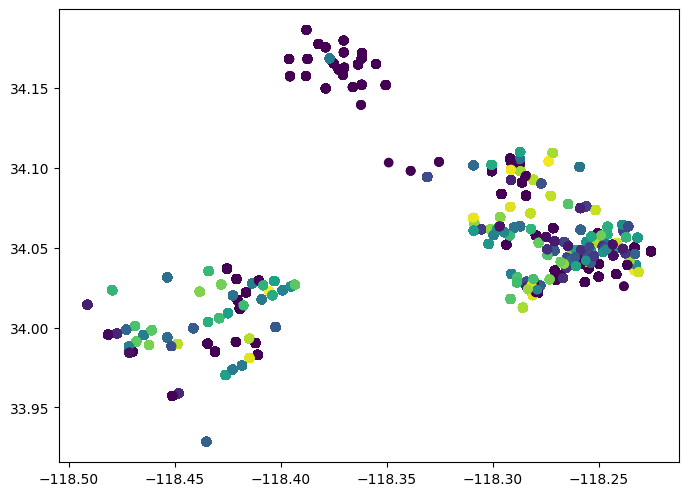

In [100]:
from sklearn.preprocessing import StandardScaler

mdl_dbscan = cluster.DBSCAN(eps=0.005, min_samples=parking_min_bikes) # eps=0.004
features = StandardScaler().fit_transform(coordinate_data) # 将特征进行归一化
mdl_dbscan.fit(features) # 聚类模型
# 模型预测的结果有多少个类，每个类有多少个样本
count = pd.Series(mdl_dbscan.labels_).value_counts()  # 展示有多少类，每类有多少个样本，即查看各个类别上的个数
print('categories  |  samples :')
print('{}'.format(count))

plt.figure()
plt.scatter(x='start_lon', y='start_lat', data=coordinate_data, c=mdl_dbscan.labels_)
# 聚类模型有两种评价模型，一种是组内距离越小越好，一种是组间距离越大越好 （组：类别）
DBI = metrics.davies_bouldin_score(coordinate_data, mdl_dbscan.labels_)
print('DBI={}'.format(DBI)) # 聚类模型评价指标

In [101]:
cluster_cnt = 3

from sklearn.cluster import KMeans

# 模型建立(预估器流程)
estimator = KMeans(n_clusters=cluster_cnt)
mdl_kmeans = estimator.fit(coordinate_data)
print(mdl_kmeans)

KMeans(n_clusters=3)


In [102]:
# 统计每个类的个数
count2 = pd.Series(mdl_kmeans.labels_).value_counts()
print(count2)

0    70631
1    64297
2    19052
dtype: int64


In [103]:
# 每个类中的坐标
km_centor = pd.DataFrame(mdl_kmeans.cluster_centers_, columns=['start_lon','start_lat'])
print(km_centor)

    start_lon  start_lat
0 -118.257872  34.046162
1 -118.454210  33.994614
2 -118.300176  34.088188


In [104]:
# 类中心
mdl_kmeans.cluster_centers_

array([[-118.25787217,   34.0461623 ],
       [-118.4542096 ,   33.99461385],
       [-118.30017626,   34.08818783]])

In [105]:
# 数量最多的十个类中心点
center_10 = list(count2.index[:10])
center_10_cordinate=[]
for index in center_10:
    cordinate = mdl_kmeans.cluster_centers_[index]
    print(cordinate)
    center_10_cordinate.append(cordinate)

[-118.25787217   34.0461623 ]
[-118.4542096    33.99461385]
[-118.30017626   34.08818783]


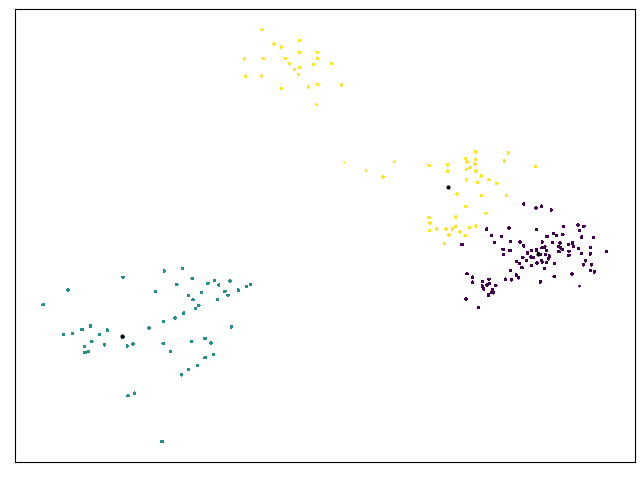

In [106]:
plt.rcParams['savefig.dpi'] = 300 # 像素
plt.rcParams['figure.dpi'] = 100 # 分辨率
plt.rcParams['figure.figsize'] = (8.0, 6.0) # 图片大小比例
plt.figure()

plt.scatter(x='start_lon', y='start_lat', data=coordinate_data, c=mdl_kmeans.labels_, s=0.5) 
plt.scatter(x='start_lon', y='start_lat', data=km_centor, c='k', s=4)
plt.scatter(x='start_lon', y='start_lat', data=center_10_cordinate, c='r', marker='*', s=20)
plt.savefig('results/cluster_kmeans.png')

### Adjust parameter

In [107]:
# 构建空列表，用于保存不同参数组合下的结果
res = list()
# 迭代不同的eps值
# for eps in np.arange(0.001,0.01,0.05):

# 迭代不同的min_samples值
for min_samples in range(20,100,20):
    dbscan = cluster.DBSCAN(eps = eps, min_samples = min_samples)
    # 模型拟合
    dbscan.fit(coordinate_data)
    # 统计各参数组合下的聚类个数（-1表示异常点）
    n_clusters = len([i for i in set(dbscan.labels_) if i != -1])
    # 异常点的个数
    outliners = np.sum(np.where(dbscan.labels_ == -1, 1, 0))
    # 统计每个簇的样本个数
    stats = str(pd.Series([i for i in dbscan.labels_ if i != -1]).value_counts().values)
    res.append({'eps':eps,'min_samples':min_samples,'n_clusters':n_clusters,'outliners':outliners,'stats':stats})

        
# 将迭代后的结果存储到数据框中        
df_params = pd.DataFrame(res)
df_params.head(10)

# 根据条件筛选合理的参数组合
df_params.loc[df_params.n_clusters == 3, :]

,eps,min_samples,n_clusters,outliners,stats


### Estimator

In [94]:
y_predict = estimator.predict(coordinate_data)
y_predict[:300]

array([1, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 1,
       1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 2, 2, 1,
       1, 2, 1, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 2,
       0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2], d

In [95]:
# 模型评估-轮廓系数 silhouette coefficient
from sklearn.metrics import silhouette_score
ss = silhouette_score(coordinate_data, y_predict) # params: 特征，标记结果
print(ss)

0.648459876853123


## Geographic Investigation & Visualisation

In [50]:
InteractiveShell.ast_node_interactivity = "last_expr"
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from common.geo_utils import GeoUtils

  statefp countyfp  countyns  geoid         name            namelsad stusab  \
0      06      037  00277283  06037  Los Angeles  Los Angeles County     CA   

  lsad classfp  mtfcc  ... cbsafp metdivfp funcstat         aland  \
0   06      H1  G4020  ...  31080    31084        A  1.051186e+10   

         awater     intptlat      intptlon  state_name countyfp_no  \
0  1.793485e+09  +34.1963983  -118.2618616  California          37   

                                            geometry  
0  MULTIPOLYGON (((-118.70339 34.16859, -118.7033...  

[1 rows x 21 columns]
Index(['statefp', 'countyfp', 'countyns', 'geoid', 'name', 'namelsad',
       'stusab', 'lsad', 'classfp', 'mtfcc', 'csafp', 'cbsafp', 'metdivfp',
       'funcstat', 'aland', 'awater', 'intptlat', 'intptlon', 'state_name',
       'countyfp_no', 'geometry'],
      dtype='object')


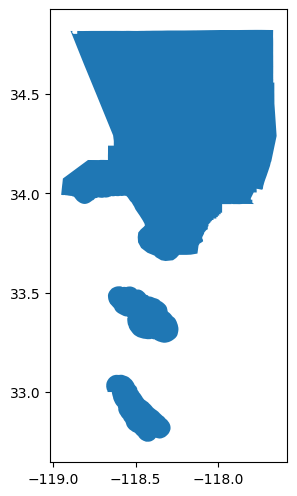

In [51]:
shapefile = GeoUtils.read_shape_file('geo_shape/us-county-boundaries.shp')
print(shapefile)
print(shapefile.keys())
la_shape = shapefile[shapefile["name"] == "Los Angeles"]
la_shape.plot()
plt.show()

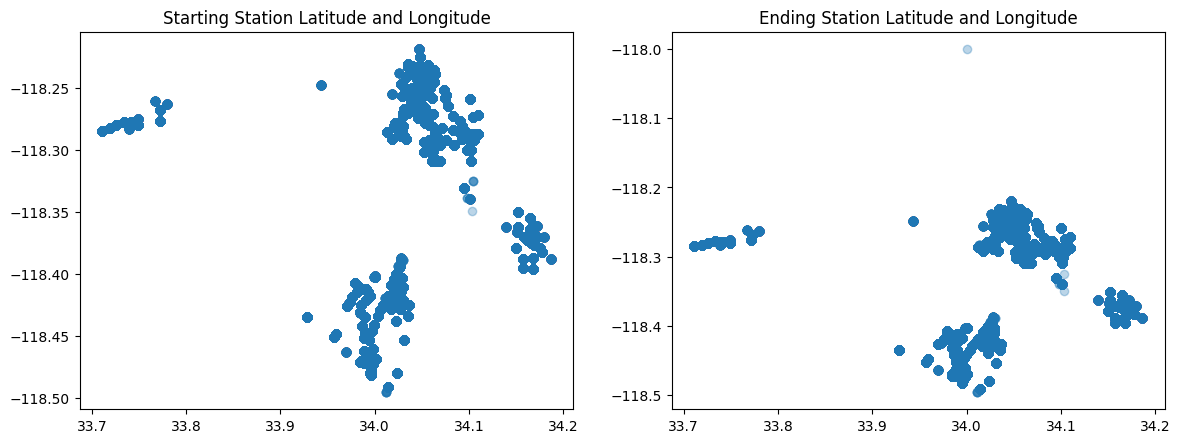

In [52]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(trip_data_by_year_df['start_lat'], trip_data_by_year_df['start_lon'],alpha=0.3)
plt.title("Starting Station Latitude and Longitude")
plt.subplot(1,2,2)
plt.scatter(trip_data_by_year_df['end_lat'], trip_data_by_year_df['end_lon'],alpha=0.3)
plt.title("Ending Station Latitude and Longitude")
plt.show()

In [53]:
# This confirms that if the Starting and Ending Stations sets are identical as expected or not
sorted(trip_data_by_year_df['start_station'].unique())==sorted(trip_data_by_year_df['end_station'].unique())

False

In [54]:
bike_map_start = folium.Map([trip_data_by_year_df['start_lat'].values[0], trip_data_by_year_df['start_lon'].values[0]])
for station in trip_data_by_year_df['start_station'].unique():
    lat = trip_data_by_year_df.loc[trip_data_by_year_df['start_station'] == station]['start_lat'].values[0]
    lon = trip_data_by_year_df.loc[trip_data_by_year_df['start_station'] == station]['start_lon'].values[0]
    marker = folium.Marker([lat,lon], popup=str(station))
    marker.add_to(bike_map_start)

bike_map_start

Almost all the stations are located in Downtown LA, Santa Monica and East Hollywood with the exception of 1 station; 1 in Willowbrook (id = 4403).

Lets look closer at the traffic to and from this 1 outlying bike stations, are they outliers?

In [55]:
trip_data_by_year_df.loc[trip_data_by_year_df['start_station']==4403]['end_station'].value_counts()

4403    64
4508    10
3014     2
3042     1
4220     1
4400     1
Name: end_station, dtype: int64

In [61]:
trip_data_by_year_df.loc[trip_data_by_year_df['end_station']==4403]['start_station'].value_counts()

4403    64
4508    24
3045     3
3025     2
4494     1
3042     1
3005     1
Name: start_station, dtype: int64

Almost all of the trips made to and from these bike stations are either round trips to the same place or from one of the two to the other. This station is almost completely disconnected from the LA network.

They also only account for a very tiny fraction of the rides total; from over 130k rides just 163 are to or from these two stations, I wonder why that is?

In [72]:
print('The first trip made FROM bike Station 4403 (Willowbrook) was on : ', trip_data_by_year_df.loc[trip_data_by_year_df['start_station']==4403]['start_datetime'].min()[:19].replace('T',' '))
print('The last trip made FROM bike Station 4403 (Willowbrook) was on : ', trip_data_by_year_df.loc[trip_data_by_year_df['start_station']==4403]['start_datetime'].max()[:19].replace('T',' '))

print('The first trip made TO bike Station 4403 (Willowbrook) was on : ', trip_data_by_year_df.loc[trip_data_by_year_df['end_station']==4403]['start_datetime'].min()[:19].replace('T',' '))
print('The last trip made TO bike Station 4403 (Willowbrook) was on : ', trip_data_by_year_df.loc[trip_data_by_year_df['end_station']==4403]['start_datetime'].max()[:19].replace('T',' '))

The first trip made FROM bike Station 4403 (Willowbrook) was on :  2020-02-19 14:53:00
The last trip made FROM bike Station 4403 (Willowbrook) was on :  2020-02-23 13:56:00
The first trip made TO bike Station 4403 (Willowbrook) was on :  2020-02-19 14:53:00
The last trip made TO bike Station 4403 (Willowbrook) was on :  2020-02-23 13:47:00


All these the trips to and from Willowbrook are on the same day; 2020-02-19 and 2020-02-23 are in the same week. What may be the case is that this station was only operational beginning that day (or that weekend), but these new stations were not used during the week as part of anyone's regular commute. Atl least not yet.

In [56]:
bike_map_end = folium.Map([trip_data_by_year_df['end_lat'].values[0], trip_data_by_year_df['end_lon'].values[0]])
for station in trip_data_by_year_df['end_station'].unique():
    lat = trip_data_by_year_df.loc[trip_data_by_year_df['end_station'] == station]['end_lat'].values[0]
    lon = trip_data_by_year_df.loc[trip_data_by_year_df['end_station'] == station]['end_lon'].values[0]
    marker = folium.Marker([lat,lon], popup=str(station))
    marker.add_to(bike_map_end)

bike_map_end

In [57]:
spark.stop()